# Practical session n°5:

## Part II: Sampling with GANs.

In this section, we aim to characterize a distribution in an image domain, rather than at the pixel level.

In high dimensions, especially on real images, the joint distribution is not modelable. It is not feasible to seek its density. However, we can attempt to sample from this distribution by relying on an existing set of images.
We will start by doing this without worrying about the conditional aspect:
in **Exercise 1**, the goal is to build a **generative model** that samples a domain of synthetic images.

Most recent generative models are primarily constructed from deep neural networks. In the field of image generation, one of the main approaches is based on **GANs** (Generative Adversarial Networks). **Exercise 1** illustrates this approach in its simplest version, while **Exercise 2** presents some variations.
Finally, **Exercise 3** gives us the opportunity to revisit the conditional aspect. The GAN approach is modified to sample from an implicit conditional distribution.

**Exercise 1** A first GAN.



The principle of GAN is simple. We have:
- A random vector $Z$, sampled from a simple distribution, for example, a centered reduced Gaussian vector.
- A generative network $G_\theta$ ($\theta$ represents the network's weights) that generates an image $G_\theta(Z)$.
- A discriminator network $D_\rho$ (similar notation as before), ending with a sigmoid function that classifies an image $x$ as "real" ($D_\rho(x) > 0.5$) or "fake" ($D_\rho(x) < 0.5$).

In the following, we omit the notations $\rho$ and $\theta$.

The algorithm consists of training $G$ and $D$ on adversarial tasks:
- $D_\rho$ is trained to distinguish images from the dataset ($x^{(i)}$) from images generated by $G_\theta$ (denoted as $G(z^{(i)})$). In the [original GAN paper](https://arxiv.org/abs/1406.2661), the authors use cross-entropy as the cost function. For a pair of two images, one fake and the other real, the cost is written as:
  $$  - {\bigg [} \ln(D(x^{(i)})) + \ln(1 - D(G(z^{(i)})) {\bigg ]}$$

- $G_\theta$ is trained to "fool" the discriminator with the adversarial cost function:
  $$  \ln(1 - D(G(z^{(i)}))) $$

A theoretical analysis of the problem is covered in the supplementary exercise sheet. Here, we implement the algorithm on synthetic images.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
# import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

In [2]:
! git clone https://github.com/relmonta/ml-student.git
! cp ml-student/TP5/* .

Cloning into 'ml-student'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 413 (delta 131), reused 149 (delta 95), pack-reused 210
Receiving objects: 100% (413/413), 77.91 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (171/171), done.
Updating files: 100% (81/81), done.
cp: -r not specified; omitting directory 'ml-student/TP5/correction'


Let's first define an image generation problem. The following function samples the random image $X$ and the random vector $Z$:

In [3]:
from utils_TP5 import *
from utils_TP5_exo3 import *

torch.Size([6, 1, 64, 64]) torch.Size([6, 1, 64, 64])


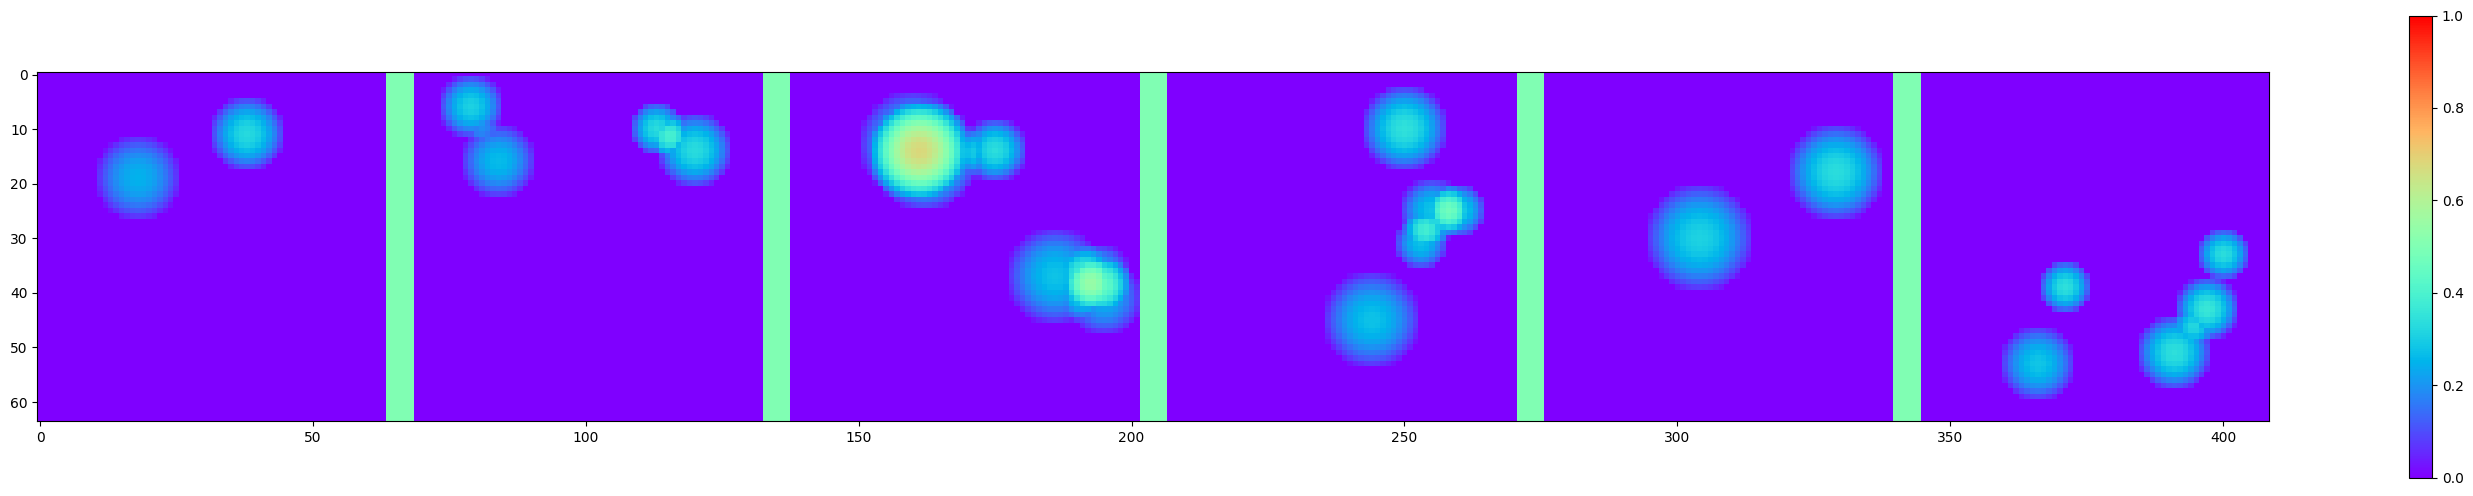

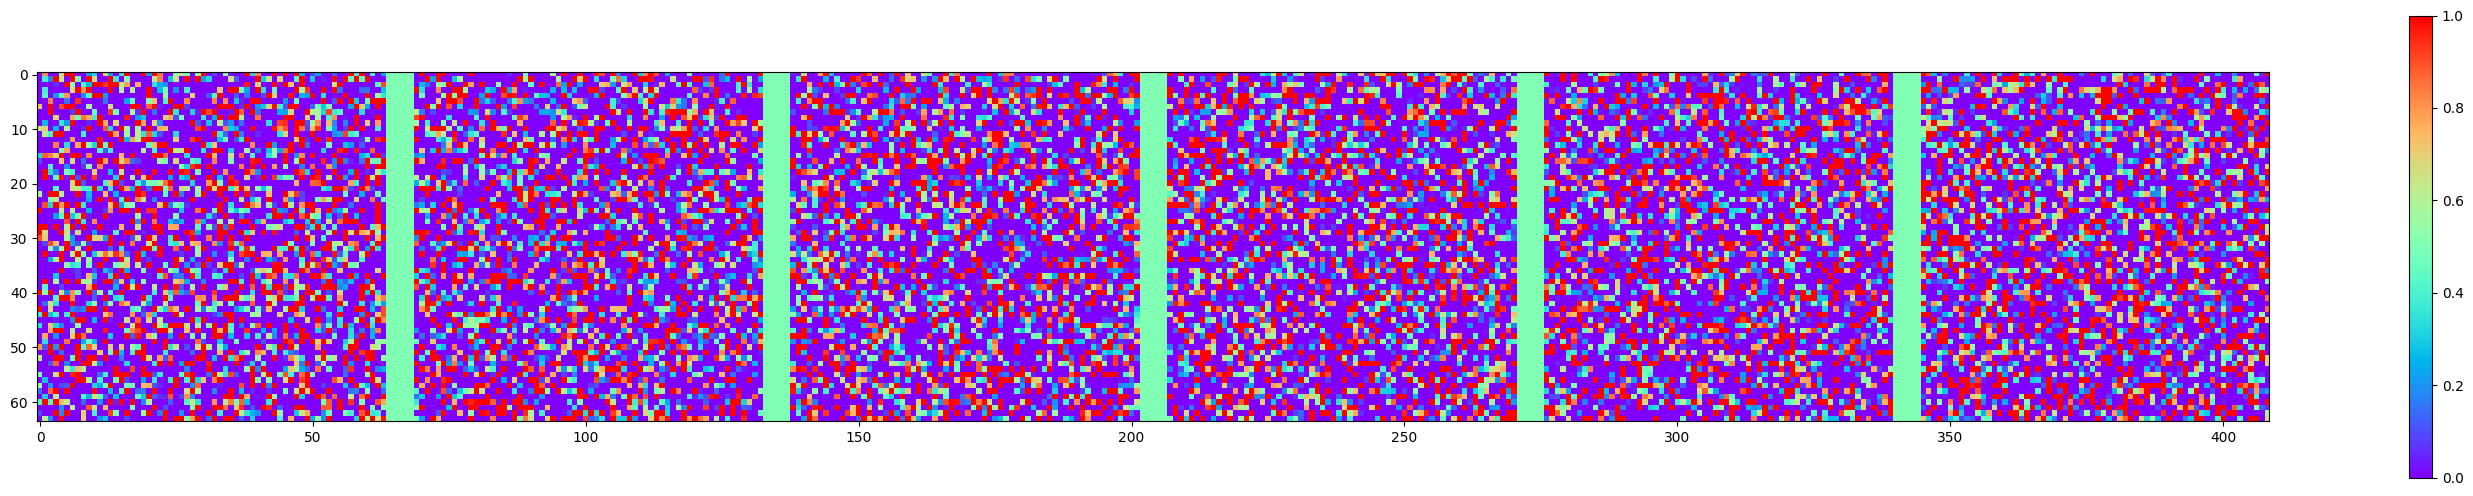

In [5]:
# Rectangle proportion in the image:
lambda_rec = 0.0

x, z = gen_DCGAN(6, lambda_rec=lambda_rec)
print(x.shape, z.shape)
# Clean versions (individual cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)

fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0, max_scale=1)

**Q1** The vector $Z$ is an image. What type of network is suitable for $G$? Instantiate it.

In [8]:
#fcn

n_channels, n_classes, size = 1, 1, 8

netG = UNet(n_channels, n_classes, size).cuda()
# netG

**Q2** The Discriminator class is used to encode the discriminator. Instantiate it and use the *weight_init* function to initialize the network's weights. What type of network do you obtain in this way?

In [9]:
ndf = 32
nc = 1


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD = Discriminator().cuda()
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)

Let's now specify some training parameters (most of them are standard for GANs):

In [10]:
# Fixing the seed (to reproduce results)
manualSeed = 1
torch.manual_seed(manualSeed)

# Number of parallel processes:
workers = 2

# Image size
image_size = 64

# Number of channels
nc = 1

# Batch size
batch_size = 64

# Number of batches per epoch
num_batches = 200
num_epochs = 10

# Learning rate
lr = 0.0002

# Beta1 hyperparameter for Adam
beta1 = 0.5  # Sometimes simply 0.

# Number of GPUs
ngpu = 1

# Cross-entropy
criterion = nn.BCELoss()

# Labels for real and fake images
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# To observe how G(z) evolves with z fixed along the training:
_ , fixed_z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
fixed_z = fixed_z.cuda()

**Q3** Launch the following code and add comments:

In [ ]:
img_list = []  # List to store generated images for visualization
G_losses = []  # List to store generator losses
D_losses = []  # List to store discriminator losses
iters = 0  # Iteration counter

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches):

        # Generate random noise and fake images using the generator
        x, z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)

        # Move real images and noise to GPU
        x = x.cuda()
        z = z.cuda()

        # STEP 1: Discriminator optimization

        # Zero the gradients of the discriminator
        netD.zero_grad()

        # Forward pass: real images
        D_real = netD(x).view(-1)

        # Create labels for real images (filled with real_label)
        b_size = x.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float).cuda()

        # Compute the loss for real images and backpropagate
        errD_real = criterion(D_real, label)
        errD_real.backward()

        # Calculate the mean value of the discriminator output for real images
        D_real = D_real.mean().item()

        # Forward pass: fake images
        fake = netG(z.cuda())
        D_fake = netD(fake.detach()).view(-1)

        # Create labels for fake images (filled with fake_label)
        label.fill_(fake_label)

        # Compute the loss for fake images and backpropagate
        errD_fake = criterion(D_fake, label)
        errD_fake.backward()

        # Combine losses for real and fake images
        errD = errD_real + errD_fake

        # Update the discriminator's weights
        optimizerD.step()

        # Calculate the mean value of the discriminator output for fake images
        D_fake = D_fake.mean().item()

        # STEP 2: Generator optimization

        # Zero the gradients of the generator
        netG.zero_grad()

        # Forward pass: fake images (again)
        D_fake2 = netD(fake).view(-1)

        # Create labels for fake images (filled with real_label)
        label.fill_(real_label)

        # Compute the loss for the generator and backpropagate
        errG = criterion(D_fake2, label)
        errG.backward()

        # Calculate the mean value of the discriminator output for fake images (again)
        D_fake2 = D_fake2.mean().item()

        # Update the generator's weights
        optimizerG.step()

        # Print and store losses and generated images
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, num_batches,
                     errD.item(), errG.item(), D_real, D_fake, D_fake2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Store generated images for visualization
        if (iters % 100 == 0) or ((epoch == num_epochs - 1) and (i == num_batches - 1)):
            with torch.no_grad():
                fake = netG(fixed_z).detach().cpu()
            img_list.append(fake)

        iters += 1


Starting Training Loop...
[0/10][0/200]	Loss_D: 1.5409	Loss_G: 0.8870	D(x): 0.5387	D(G(z)): 0.5998 / 0.4136
[0/10][50/200]	Loss_D: 0.0223	Loss_G: 7.3312	D(x): 0.9934	D(G(z)): 0.0147 / 0.0014
[0/10][100/200]	Loss_D: 0.6321	Loss_G: 1.2333	D(x): 0.6213	D(G(z)): 0.1136 / 0.3188
[0/10][150/200]	Loss_D: 0.8293	Loss_G: 1.5140	D(x): 0.7463	D(G(z)): 0.4044 / 0.2277
[1/10][0/200]	Loss_D: 0.9793	Loss_G: 3.4829	D(x): 0.9203	D(G(z)): 0.5774 / 0.0455
[1/10][50/200]	Loss_D: 1.1321	Loss_G: 1.9412	D(x): 0.7338	D(G(z)): 0.5460 / 0.1488
[1/10][100/200]	Loss_D: 1.2690	Loss_G: 1.2008	D(x): 0.5538	D(G(z)): 0.4755 / 0.3077
[1/10][150/200]	Loss_D: 1.5760	Loss_G: 0.3677	D(x): 0.3243	D(G(z)): 0.3496 / 0.6950
[2/10][0/200]	Loss_D: 1.1251	Loss_G: 1.3872	D(x): 0.6212	D(G(z)): 0.4679 / 0.2597
[2/10][50/200]	Loss_D: 1.3729	Loss_G: 0.6290	D(x): 0.3717	D(G(z)): 0.3084 / 0.5382
[2/10][100/200]	Loss_D: 1.6499	Loss_G: 0.6460	D(x): 0.2729	D(G(z)): 0.2582 / 0.5305
[2/10][150/200]	Loss_D: 1.3247	Loss_G: 2.6365	D(x): 0.7925	

**Q4** Plot the evolution of the cost functions for the generator and discriminator. Observe the generated images and comment.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Q5** Restart training with additional rectangles on the image. Visualize and comment on the results.

In [ ]:
# Rectangle proportion in the image :
lambda_rec = 0.00025

x , z = gen_DCGAN(6,lambda_rec = lambda_rec)

# Propre versions (only cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0,max_scale=1)


fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0,max_scale=1)

**Exercise n°2** Wasserstein-GANs.

To facilitate the convergence of GANs, several approaches have been explored. In particular:
- Giving the discriminator more time to converge at each step.
- Keep the Lipschitzianity of the discriminator. This option takes its root in an interesting theoretical approach (see the supplementary exercise sheet). It can be done:

  * by constraining the weights of the discriminator to remain within a given interval (see the paper introducing WGANs [(Wasserstein-GANs)](https://arxiv.org/abs/1701.07875).

  * by [gradient penalization](https://arxiv.org/pdf/1704.00028.pdf)   

**Q2** In the following cells, these three approaches are coded. Say where.

In [ ]:
nc = 1
ndf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def calculate_gradient_penalty(model, real_images, fake_images):
    alpha = torch.randn((real_images.size(0), 1, 1, 1)).cuda()
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), requires_grad=False).cuda()

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [ ]:
n_channels, n_classes,size = 1, 1, 16
netG = UNet(n_channels, n_classes, size).cuda()

netD = Discriminator()
netD.apply(weights_init)
netD = netD.cuda()

In [ ]:
# Proportion of rectangle in the image:
lambda_rec = 0.00025

# Fixing the seed for reproducibility:
manualSeed = 1
torch.manual_seed(manualSeed)

# Number of parallel processes:
workers = 2

# Image size:
image_size = 64

# Number of channels:
nc = 1

# Batch size:
batch_size = 64

# Number of batches per epoch (for the generator):
num_batches_generator = 200
num_epochs = 30

# Learning rate:
lr = 0.0001

# Beta1 hyperparameter for Adam:
beta1 = 0.  # In the paper introducing gradient penalty

# Number of GPUs:
ngpu = 1

# Cross-entropy & label conventions:
criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

# Gradient penalty (gp) or classic WGAN:
add_gp = True

# Setup Adam optimizers for both G and D:
# If gradient penalty:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# If not:
# optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

# Schedulers:
step_size = 31
gamma = 0.2
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=step_size, gamma=gamma)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=step_size, gamma=gamma)

In [ ]:
# To observe how G(z) evolves with fixed z during training:
_ ,  fixed_z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
fixed_z = fixed_z.cuda()

In [ ]:
img_list = []
G_losses = []
D_losses = []

n_critic = 5
clip = 0.01

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches_generator):
        netG.train()
        for j in range(n_critic):
            x , z = gen_DCGAN(batch_size, lambda_rec = lambda_rec)


            netD.zero_grad()
            real = x.cuda()
            output_real = netD(real)
            fake = netG(z.cuda())
            output_fake = netD(fake.detach())

            # Ici, on limite les gradients du discriminateur:
            if add_gp:
                gradient_penalty = calculate_gradient_penalty(netD,
                                                   real.data, fake.data)
                errD = output_fake.mean() - output_real.mean() + 10 * gradient_penalty

            else :
                errD = output_fake.mean() - output_real.mean()

            errD.backward()

            # Update D
            optimizerD.step()

            if not add_gp:
                for p in netD.parameters():
                    p.data.clamp_(-clip, clip)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
#        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake = netG(z.cuda())
        output_fake = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = - output_fake.mean()
        # Calculate gradients for G
        errG.backward()
#        D_G_z2 =  - output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_z.cuda()).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=False))
    img_list.append(fake)


    schedulerD.step()
    schedulerG.step()


**Q3** Plot the learning curves and some gerated outputs. Can we still observe mode collapse in these images?

**Q4** Let's finally see the results of training over several hours. Load the UNet trained for 600 epochs (*netG_600.pt*) and visualize the generated images.

In [ ]:
n_channels, n_classes,size = 1, 1, 16
netG_600ep = UNet(n_channels, n_classes, size).cuda()
path_netG = "Ex2_netG_600ep_WGP_lr0001.pt"

#TO DO

**Exercice n°3** A conditional GAN.  




In this exercise, the goal is to implement a conditional Wasserstein-GAN. Once again, theoretical aspects are set aside; the objective is solely to construct the training loop.
The context is as follows: we have a set of images representing a domain 𝒟.
The traditional GAN generates new images from 𝒟. In this exercise, we will generate images compatible with a given list of pixel values a priori.

The following cells allow visualization of the available dataset.


In [ ]:
# Proportion of pixels preserved in yi:
obs_density = 0.005

x, y, z = gen_condDCGAN(6, obs_density)

# Full images xi
fig1 = plt.figure(1, figsize=(36, 6))
visualize_2D_batch(x, 6, fig1, k=0, min_scale=0, max_scale=1)

# Fragmentary images yi: a few pixels randomly sampled from xi
fig2 = plt.figure(2, figsize=(36, 6))
visualize_2D_batch(y, 6, fig2, k=0, min_scale=-0.2, max_scale=1)

# zi: sample from a centered reduced Gaussian vector
fig3 = plt.figure(3, figsize=(36, 6))
visualize_2D_batch(z, 6, fig3, k=0, min_scale=0, max_scale=1)

**Q1** Drawing inspiration from the previous exercise, complete the training loop and run it for ten epochs:

In [ ]:
# SGD Setup
batch_size = 128
num_batches_generator = 200
num_epochs = ...


# Optimizer Parameters
lr = 0.0005
beta1 = 0.  # SGD momentum

# nn setup
ndf = 32
n_channels = ...
n_classes = ...
size = 16

netG = UNet(n_channels, n_classes, size).cuda()
netD = Discriminator(n_channels).cuda()

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
real_label = 1.
fake_label = 0.

In [ ]:
# To keep track of generated images from a fixed sample of $z_i$:
fixed_x, fixed_y, fixed_z = gen_condDCGAN(8, p=dens_obs)

# Fixed input for the generator:
fixed_yz = torch.cat((fixed_y, fixed_z), dim=1).cuda()

# Lists
img_list = []
G_losses = []
D_losses = []

# Other hyperparameters
n_critic = 5
clip = 0.01

In [ ]:
criterion = nn.BCELoss()
print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i in range(num_batches_generator):

        ############################
        # (1) Maximization of log(D(x)) + log(1 - D(G(z)))
        ###########################
        netG.train()
        # Here, we perform multiple (n_critic) optimization steps for the discriminator.
        for j in range(n_critic):

            x, y, z = gen_condDCGAN(batch_size, p=dens_obs)

            # Move to GPU
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()

            # Concatenations:
            xy = torch.cat((x, y))
            yz = torch.cat((y, z))

            output_xy = netD(xy)

            fake = netG(yz)
            fake = fake.detach()

            fakey = torch.cat((fake, y), dim=1)
            output_fakey = netD(fakey)

            # Regularization by gradient penalty
            gradient_penalty = calculate_gradient_penalty(netD, xy.data, fakey.data)

            # Calculate discriminator error and update gradients:
            label = torch.full((xy.size(0),), real_label, dtype=torch.float).cuda()
            err_D_real = criterion(output_xy.view(-1), label)
            errD_real.backward()
            label.fill_(fake_label)
            errD_fake = criterion(output_fakey, label)
            errD_fake.backward()

            errD = err_D_real + errD_fake  # In case we want to store it later

            optimizerD.step()

        ############################
        # Maximization of log(D(G(z)))
        ###########################
        netG.zero_grad()

        fake = netD(fake).view(-1)
        fakey = torch.cat((fake, y), dim=1)

        output_fakey = netD(fakey)

        errG = -output_fakey.mean()
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch + 1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Record losses
        G_losses.append(errG.item())
        D_losses.append(-errD.item())

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_yz.cuda()).detach().cpu()

    img_list.append(fake)

**Q2** Visualize some images and comment on them.

**Q3** To obtain a GAN that takes into account the condition contained in $y_i$, it is necessary to push the training further. The file *netG_180ep_WGP_scheduler75_lr005.pt* contains the weights obtained after training for 300 epochs. Load these weights and visualize several images for the same inputs $x_i$ and $z_i$. Check the coherence and draw conclusions.